In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition


In [11]:
#os.chdir('../Python/DinAE/CodeVarModelNN_Neurips2020/')
#!ls

__pycache__
data
mnist_4DVarTorch_2SCNN_Grad_01_02_15_modelAE.mod
mnist_4DVarTorch_2SCNN_Grad_01_02_15_modelGrad.mod
mnist_4DVarTorch_v2_AEMLP20_Grad_01_02_15_modelAE_iter175.mod
mnist_4DVarTorch_v2_AEMLP20_Grad_01_02_15_modelGrad_iter175.mod
mnist_VarModelNN_PCA50_Grad_01_02_20_modelAE.mod
mnist_VarModelNN_PCA50_Grad_01_02_20_modelGrad.mod
notebookPyTorch_VarModelNN_MNIST_Neurips2020.ipynb
torch_4DVarNN_dinAE.py


In [12]:
# Check that torch_4DVarNN_dinAE.py is in the current directory
import torch_4DVarNN_dinAE as NN_4DVar

In [13]:
flagRandomSeed = 0
if flagRandomSeed == 0:
  print('........ Random seed set to 100')
  np.random.seed(100)
  torch.manual_seed(100)
Nsquare  = int(3)
Wsquare  = int(4)
sigNoise = 0.1#0.25#

........ Random seed set to 100


In [14]:
import torchvision.datasets as datasets

if 1*1 :
  mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
  mnist_testset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)
else:
  mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)
  mnist_testset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=None)


x_train = mnist_trainset.data.cpu().detach().numpy()
y_train = mnist_trainset.targets.cpu().detach().numpy()

x_test = mnist_testset.data.cpu().detach().numpy()
y_test = mnist_testset.targets.cpu().detach().numpy()

#meanTr     = np.mean(x_train,0)
meanTr     = np.mean(x_train)
x_train    = x_train - meanTr
x_test     = x_test  - meanTr

# scale wrt std
stdTr      = np.sqrt( np.mean( x_train**2 ) )
x_train    = x_train / stdTr
x_test     = x_test  / stdTr
stdTt      = np.sqrt( np.mean( x_test**2 ) )
              
# generate missing data areas for training data            
x_train_missing = np.copy(x_train).astype(float)
mask_train      = np.zeros((x_train.shape))
mask_test       = np.zeros((x_test.shape))

for ii in range(x_train.shape[0]):
  # generate mask
  mask   = np.ones((x_train.shape[1],x_train.shape[2])).astype(float)
  i_area = np.floor(np.random.uniform(Wsquare,x_train.shape[1]-Wsquare,Nsquare)).astype(int)
  j_area = np.floor(np.random.uniform(Wsquare,x_train.shape[2]-Wsquare,Nsquare)).astype(int)
  
  for nn in range(Nsquare):
    mask[i_area[nn]-Wsquare:i_area[nn]+Wsquare+1,j_area[nn]-Wsquare:j_area[nn]+Wsquare+1] = 0.
    
  # apply mask
  x_train_missing[ii,:,:] *= mask
  mask_train[ii,:,:]       = mask     
  
## generate missing data areas for test data
x_test_missing = np.copy(x_test).astype(float)

for ii in range(x_test.shape[0]):
  # generate mask
  mask   = np.ones((x_test.shape[1],x_test.shape[2])).astype(float)
  i_area = np.floor(np.random.uniform(Wsquare,x_test.shape[1]-Wsquare,Nsquare)).astype(int)
  j_area = np.floor(np.random.uniform(Wsquare,x_test.shape[2]-Wsquare,Nsquare)).astype(int)
  
  for nn in range(Nsquare):
    mask[i_area[nn]-Wsquare:i_area[nn]+Wsquare+1,j_area[nn]-Wsquare:j_area[nn]+Wsquare+1] = 0.
    
  # apply mask
  x_test_missing[ii,:,:] *= mask
  mask_test[ii,:,:]       = mask

# Generate noisy observsation
x_train_obs = x_train_missing + sigNoise * mask_train * np.random.randn(x_train_missing.shape[0],x_train_missing.shape[1],x_train_missing.shape[2])
x_test_obs  = x_test_missing  + sigNoise * mask_test * np.random.randn(x_test_missing.shape[0],x_test_missing.shape[1],x_test_missing.shape[2])

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


..... Training dataset: 60000x28x28
..... Test dataset    : 10000x28x28


In [15]:
# Initialization for interpolation
x_train_Init = np.copy(x_train_obs)
x_test_Init  = np.copy(x_test_obs)

In [16]:
# random selection of indices for visualization
indexes_train = np.random.permutation(x_train.shape[0])
indexes_test  = np.random.permutation(x_test.shape[0])

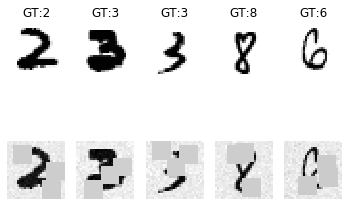

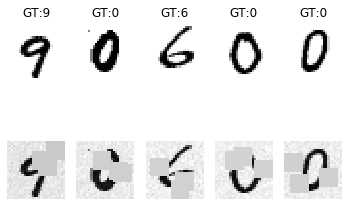

In [17]:
# visualize missing data pattern for training data
plt.figure()
for ii in range(5):
    plt.subplot(2, 5, ii + 1)
    plt.axis('off')
    plt.imshow(x_train[indexes_train[ii],:,:], cmap=plt.cm.gray_r)
    plt.title('GT:%i' %(y_train[indexes_train[ii]]))
    plt.subplot(2, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(x_train_obs[indexes_train[ii],:,:], cmap=plt.cm.gray_r)
plt.show()

# visualize missing data pattern for test data
plt.figure()
for ii in range(5):
    plt.subplot(2, 5, ii + 1)
    plt.axis('off')
    plt.imshow(x_test[indexes_test[ii],:,:], cmap=plt.cm.gray_r)
    plt.title('GT:%d' %int(y_test[indexes_test[ii]]))
    plt.subplot(2, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(x_test_obs[indexes_test[ii],:,:], cmap=plt.cm.gray_r)
plt.show()

In [18]:
DimAE      = 50#50
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))

rec_PCA_Tt       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))**2 )
var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

# visualize PCs and associated projection
PC              = np.zeros((DimAE+1,x_test.shape[1]*x_test.shape[2])) * float('NaN')                        
PC[1:DimAE+1,:] = pca.components_
PC[0,:]         = pca.mean_
PC              = np.reshape(PC,(DimAE+1,x_test.shape[1],x_test.shape[2]))

.......... PCA Dim = 50
.... explained variance PCA (Tr) : 82.46%
.... explained variance PCA (Tt) : 82.98%


# Create AE architecture

In [19]:
print('........ Define AE architecture')

## change depending on the considered prior

## PCA-based parameterization
if 1*1 :
    flagAEType = 0
    DimAE      = 50

## AE-based parameterization
if 1*0 :
    flagAEType = 1
    DimAE      = 20

## 2S-CNN parameterization
if 1*1 :
    flagAEType = 2
    DimAE      = 50

shapeData    = np.ones(3).astype(int)
shapeData[1:] =  x_train.shape[1:]

if flagAEType == 1: ## MLP-AE
  genSuffixModel = 'AEMLP%02d'%DimAE  

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.fc1 = torch.nn.Linear(shapeData[1]*shapeData[2],6*DimAE)
          self.fc2 = torch.nn.Linear(6*DimAE,2*DimAE)
          self.fc3 = torch.nn.Linear(2*DimAE,DimAE)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          self.fc1 = torch.nn.Linear(DimAE,10*DimAE)
          self.fc2 = torch.nn.Linear(10*DimAE,20*DimAE)
          self.fc3 = torch.nn.Linear(20*DimAE,shapeData[0]*shapeData[1]*shapeData[2])

      def forward(self, x):
          x = self.fc1( x )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x
    
elif flagAEType == 0: ## PCA
  genSuffixModel = 'PCA%02d'%DimAE  

  # train PCA
  pca           = decomposition.PCA(DimAE)
  pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
  pcs_ = pca.components_[0:DimAE,:]
    
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.fc1 = torch.nn.Linear(shapeData[1]*shapeData[2],DimAE,bias=False)
          self.fc1.weight = torch.nn.Parameter( torch.Tensor( pcs_ ))
          self.mean_ = torch.nn.Parameter( torch.Tensor( pca.mean_ ) )
          
      def forward(self, x):
          x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) - self.mean_ )
          return x
    
  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          self.fc1 = torch.nn.Linear(DimAE,shapeData[0]*shapeData[1]*shapeData[2],bias=False)
          self.fc1.weight = torch.nn.Parameter( torch.Tensor( pcs_.transpose() ) )
          self.mean_ = torch.nn.Parameter( torch.Tensor( pca.mean_ ) )
      def forward(self, x):
          x = self.fc1( x ) + self.mean_
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

elif flagAEType == 2: ## Conv model with no use of the central point
  genSuffixModel = '2SCNN'  

  dW = 5
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1  = torch.nn.AvgPool2d(4)
          self.conv1  = torch.nn.Conv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.conv2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)

          self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
          #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,1,(4,4),stride=(4,4),bias=False)          
          #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
          #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
          #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)

          self.convHR1  = torch.nn.Conv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
          self.convHR2  = torch.nn.Conv2d(2*DimAE,DimAE,(3,3),padding=1,bias=False)

          self.convHR21 = torch.nn.Conv2d(DimAE,DimAE,(3,3),padding=1,bias=False)
          self.convHR22 = torch.nn.Conv2d(DimAE,DimAE,(3,3),padding=1,bias=False)
          self.convHR23 = torch.nn.Conv2d(DimAE,DimAE,(3,3),padding=1,bias=False)
          self.convHR3  = torch.nn.Conv2d(2*DimAE,1,(3,3),padding=1,bias=False)

      def forward(self, xinp):
          #x = self.fc1( torch.nn.Flatten(x) )
          #x = self.pool1( xinp )
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          #x = self.conv5( F.relu(x) )
          #x = self.conv6( F.relu(x) )

          xHR = self.convHR1( xinp )
          xHR = self.convHR2( F.relu(xHR) )
          xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
          xHR = self.convHR3( xHR )

          x   = torch.add(x,1.,xHR)

          #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE           = Model_AE()
print('AE Model type: '+genSuffixModel)
print(model_AE)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))

........ Define AE architecture
AE Model type: 2SCNN
Model_AE(
  (encoder): Encoder(
    (pool1): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (conv1): Conv2d(1, 100, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
    (conv2): Conv2d(100, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv21): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv22): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv23): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv3): Conv2d(100, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv2Tr): ConvTranspose2d(50, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (convHR1): Conv2d(1, 100, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
    (convHR2): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (convHR21): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (convHR22):

# Evaluation of pre-trained models

In [25]:
UsePriodicBoundary = False # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
InterpFlag         = False

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(".... Device GPU: "+str(torch.cuda.is_available()))

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )
              
alpha4DVar      = np.array([0.1,1.])
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent

NBGradCurrent   = 20
NBProjCurrent   = 0
batch_size      = 128

model           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,NBProjCurrent,NBGradCurrent,GradType,OptimType,InterpFlag,UsePriodicBoundary)        
#model           = NN_4DVar.Model_4DVarNN_Grad(model_AE,shapeData,NBGradCurrent,GradType,OptimType,InterpFlag,UsePriodicBoundary)        
        
model           = model.to(device)
print('4DVar model: Number of trainable parameters = %d'%(sum(p.numel() for p in model.parameters() if p.requires_grad)))
              
# models considered in neurips preprint
if( flagAEType == 2 ):
    fileAEModelInit = 'mnist_4DVarTorch_2SCNN_Grad_01_02_15_modelAE.mod'
elif flagAEType == 0 :                
    fileAEModelInit = 'mnist_VarModelNN_PCA50_Grad_01_02_20_modelAE.mod'
elif flagAEType == 1 :                
    fileAEModelInit = 'mnist_4DVarTorch_v2_AEMLP20_Grad_01_02_15_modelAE.mod'
print('.... load model: '+fileAEModelInit)

model.model_AE.load_state_dict(torch.load(fileAEModelInit))
model.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE','_modelGrad')))

.... Device GPU: True
Opitm type 2
4DVar model: Number of trainable parameters = 157008
.... load model: mnist_4DVarTorch_2SCNN_Grad_01_02_15_modelAE.mod


<All keys matched successfully>

In [26]:
print('... Number of GPUs: %d'%torch.cuda.device_count())
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  modelMultiGPU = torch.nn.DataParallel(model)
else:
  modelMultiGPU = model

modelMultiGPU.to(device)

... Number of GPUs: 4
Let's use 4 GPUs!


DataParallel(
  (module): Model_4DVarNN_GradFP(
    (model_AE): Model_AE(
      (encoder): Encoder(
        (pool1): AvgPool2d(kernel_size=4, stride=4, padding=0)
        (conv1): Conv2d(1, 100, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
        (conv2): Conv2d(100, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv21): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv22): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv23): Conv2d(50, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv3): Conv2d(100, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv2Tr): ConvTranspose2d(50, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
        (convHR1): Conv2d(1, 100, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
        (convHR2): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convHR21): Conv2d(50, 50, kernel_size=(3, 3),

In [27]:
batch_size = 64

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

y_train = np.zeros(x_train.shape)
y_test  = np.zeros(x_test.shape)


# training function for dinAE
# Each epoch has a training and validation phase
for phase in ['val']:        
#for phase in ['train', 'val']:        

    since = time.time()

    model.eval()

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    running_loss_Obs_GT  = 0.
    num_loss             = 0
    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        if( np.mod(idx,500) == 0) :
            print(".. "+phase+" data %d"%idx)
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))


        # reshaping tensors
        inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
        inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                
        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks)

            # store interpolation/reconstruction results
            if phase == 'train':
              y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy().squeeze()
            else:
              y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy().squeeze()

            idx += inputs_missing.size(0)

            #outputs = model(inputs_init,inputs_missing,masks)
            
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
            loss_Obs_GT = torch.sum((targets_GT - inputs_missing)**2 * masks ) / torch.sum(masks)

            # backward + optimize only if in training phase
                            
        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_Obs_GT      += loss_Obs_GT.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss
    epoch_loss_Obs_GT= running_loss_Obs_GT / num_loss
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]

    #epoch_loss_All   = epoch_loss_All * stdTr**2
    #epoch_loss_I     = epoch_loss_I * stdTr**2
    #epoch_loss_R     = epoch_loss_R * stdTr**2
    #epoch_loss_Obs   = epoch_loss_Obs * stdTr**2
    #epoch_loss_Obs_GT= epoch_loss_Obs_GT * stdTr**2
    #epoch_loss_AE    = epoch_loss_AE * stdTr**2
    #epoch_loss_AE_GT = epoch_loss_AE_GT * stdTr**2
    
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE
    epoch_loss_4DVar_GT = alpha4DVar[0] * epoch_loss_Obs_GT + alpha4DVar[1] * epoch_loss_AE_GT

    print('{} Loss4DVar: {:.4e} R-Score: {:.4e} I-Score: {:.4e} AE-Score-GT: {:.4e}'.format(
        phase, epoch_loss_4DVar, epoch_loss_All,epoch_loss_I,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

.. val data 0


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


.. val data 8000
val Loss4DVar: 1.3776e-02 R-Score: 9.2066e-02 I-Score: 3.3397e-01 AE-Score: 1.3224e-02 AE-Score-GT: 2.3865e-02
Eval. time in 1m 28s


In [16]:
if( flagAEType == 2 ) :
    y_test_2SCNN   = np.copy(y_test)
    err_test_2SCNN = np.sum(np.sum( (y_test_2SCNN[:,:,:]-x_test[:,:,:])**2,2),1) / (28*28)  
elif flagAEType == 0 :                
    y_test_PCA   = np.copy(y_test)
    err_test_PCA = np.sum(np.sum( (y_test_PCA[:,:,:]-x_test[:,:,:])**2,2),1) / (28*28)
elif flagAEType == 1 :                
    y_test_AE   = np.copy(y_test)
    err_test_AE = np.sum(np.sum( (y_test_AE[:,:,:]-x_test[:,:,:])**2,2),1) / (28*28)

In [17]:
# Evaluation for specific examples

In [18]:
np.random.seed(100)
idxTt    = np.random.permutation(x_test.shape[0])[0:50]

Text(0.5, 1.0, 'NN model 7.8763e-02')

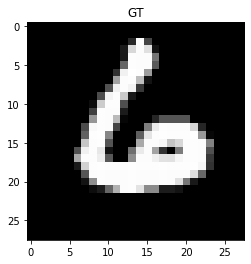

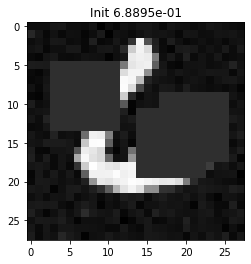

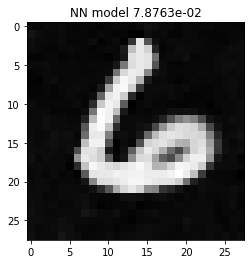

In [19]:
## Visualisation
#idxTr = np.random.permutation(y_train.shape[0])[0:2]
#idxTt = np.random.permutation(y_test.shape[0])[0:10]
ii = 0

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('GT')

#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_test_Init[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('Init %.4e'%np.mean( (x_test_Init[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))

#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_test[idxTt[ii],:,:])**2 ))


In [ ]:
#Variational reconstruction using pre-trained prior and fixed-step gradient descent

In [20]:
#ii         = 3

# Variational assimilation reconstruction
# for test data indices idxTt
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('... alphaObs %.3f'%model.model_Grad.compute_Grad.alphaObs.item())    
print('... alphaPrior %.3f'%model.model_Grad.compute_Grad.alphaAE.item())    
print('... AEType %d'%flagAEType)

# model creation
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
alpha4DVar      = [model.model_Grad.compute_Grad.alphaObs.item(),model.model_Grad.compute_Grad.alphaAE.item()]
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations
NiterGrad       = 20 # Number of gradient descent step

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

StepLoss   = 50
NIter      = 5000#650#1601#5000#
delta      = 2e2
idxTtOneBatch = idxTt#[ii:ii+1]
batch_size    = len(idxTtOneBatch)

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTtOneBatch,:,:]),torch.Tensor(x_test_obs[idxTtOneBatch,:,:]),torch.Tensor(mask_test[idxTtOneBatch,:,:]),torch.Tensor(x_test[idxTtOneBatch,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    print(x_GT.size())
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = model(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = model(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = model(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Fixed-step gradient-based descent of the variational cost')

    # AE projection
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    
    for kk in range(0,NIter):
        # AE projection
        x_pred = model.model_AE( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)
        loss_IGT = torch.sum((xhat - x_GT)**2 * (1.-masks)) / torch.sum( 1.-masks)

        # overall loss
        loss = alpha4DVar[0] * loss_obs + alpha4DVar[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)
                
        if( kk == 0 ):
            xhatBest = xhat.detach()
            lossBest = loss_GT.detach()
        else:
            if( loss_GT < lossBest ):
                xhatBest = xhat.detach()
                lossBest = loss_GT.detach()
                
        # evaluate and store losses
        if( np.mod(kk,StepLoss) == 0 ):  

            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
            compt_kk = compt_kk + 1
loss4DVar     = losses_test
y_pred_VarMin = xhat.detach().cpu().numpy()
   
if( flagAEType == 2 ) :
  loss4DVar2SCNN = losses_test
  y_pred_VarMin2SCNN = xhatBest.detach().cpu().numpy()
elif flagAEType == 0 :                
  loss4DVarPCA = losses_test
  y_pred_VarMinPCA = xhatBest.detach().cpu().numpy()
elif flagAEType == 1 :                
  loss4DVarAE = losses_test
  y_pred_VarMinAE = xhatBest.detach().cpu().numpy()


... alphaObs 1.014
... alphaPrior 0.719
... AEType 2
.....
..... alpha : obs 1.014 --- dyn 0.719
torch.Size([50, 28, 28])
..........................................
.....
..... Loss (trained Grad model) #d:  GT 7.419685e-02   ---  dyn 1.390019e-02   ---  obs 5.554240e-03
.....
.....
..... Fixed-step gradient-based descent of the variational cost
..... Loss Grad Descent 0:  4DVar 5.153771e-02   ---  GT 4.472089e-01   ---  Interp GT 1.629308e+00   ---  dyn 7.172198e-02   ---  obs 0.000000e+00
..... Loss Grad Descent 50:  4DVar 2.871127e-02   ---  GT 4.211662e-01   ---  Interp GT 1.546627e+00   ---  dyn 3.366743e-02   ---  obs 4.456586e-03
..... Loss Grad Descent 100:  4DVar 2.605120e-02   ---  GT 4.051227e-01   ---  Interp GT 1.486470e+00   ---  dyn 2.813328e-02   ---  obs 5.755138e-03
..... Loss Grad Descent 150:  4DVar 2.457739e-02   ---  GT 3.918820e-01   ---  Interp GT 1.437255e+00   ---  dyn 2.572346e-02   ---  obs 6.009431e-03
..... Loss Grad Descent 200:  4DVar 2.351138e-02   --- 

..... Loss Grad Descent 2650:  4DVar 1.557608e-02   ---  GT 1.944624e-01   ---  Interp GT 7.084187e-01   ---  dyn 1.440561e-02   ---  obs 5.152787e-03
..... Loss Grad Descent 2700:  4DVar 1.553711e-02   ---  GT 1.927798e-01   ---  Interp GT 7.021922e-01   ---  dyn 1.435531e-02   ---  obs 5.150013e-03
..... Loss Grad Descent 2750:  4DVar 1.549917e-02   ---  GT 1.911356e-01   ---  Interp GT 6.961086e-01   ---  dyn 1.430665e-02   ---  obs 5.147067e-03
..... Loss Grad Descent 2800:  4DVar 1.546208e-02   ---  GT 1.895200e-01   ---  Interp GT 6.901307e-01   ---  dyn 1.425860e-02   ---  obs 5.144548e-03
..... Loss Grad Descent 2850:  4DVar 1.542591e-02   ---  GT 1.879343e-01   ---  Interp GT 6.842644e-01   ---  dyn 1.421155e-02   ---  obs 5.142221e-03
..... Loss Grad Descent 3000:  4DVar 1.532184e-02   ---  GT 1.833566e-01   ---  Interp GT 6.673254e-01   ---  dyn 1.407656e-02   ---  obs 5.135243e-03
..... Loss Grad Descent 3050:  4DVar 1.528867e-02   ---  GT 1.818875e-01   ---  Interp GT 6.61

In [94]:
# Sequential application of the trained model

In [21]:
# Sequential version of tre trained solver
# for idxTt samples
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model creation
batch_size      = len(idxTtOneBatch)
alpha           = np.array([1.,0.1])
alpha4DVar      = np.array([0.1,1.])
alpha4DVar      = [model.model_Grad.compute_Grad.alphaObs.item(),model.model_Grad.compute_Grad.alphaAE.item()]
GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
OptimType       = 2 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
NiterProjection = 0 # Number of fixed-point iterations

print('.....')
print('..... alpha : obs %.3f --- dyn %.3f'%(alpha4DVar[0],alpha4DVar[1]))

#dt    = 0.01

if( flagAEType == 2 ) :
  NIter  = 15
elif flagAEType == 0 :                
  NIter  = 20
elif flagAEType == 1 :                
  NIter  = 15

# Apply current model to data
test_dataset_OneBatch = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init[idxTtOneBatch,:,:]),torch.Tensor(x_test_obs[idxTtOneBatch,:,:]),torch.Tensor(mask_test[idxTtOneBatch,:,:]),torch.Tensor(x_test[idxTtOneBatch,:,:])) # create your datset
dataloaders = {
    'val': torch.utils.data.DataLoader(test_dataset_OneBatch, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
}

x_test_pred  = []

compt   = 0
numData = 0

loss_dyn1 = torch.Tensor([0.0])
loss_obs1 = torch.Tensor([0.0])
loss_GT1  = torch.Tensor([0.0])            

phase   = 'val'
for x_init,x_obs,masks,x_GT in dataloaders[phase]:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)
    
    # reshaping tensors
    x_init   = x_init.view(-1,1,x_init.size(1),x_init.size(2))
    x_obs    = x_obs.view(-1,1,x_obs.size(1),x_obs.size(2))
    masks    = masks.view(-1,1,masks.size(1),masks.size(2))
    x_GT     = x_GT.view(-1,1,x_GT.size(1),x_GT.size(2))

    #for phase in ['train', 'val']:    
    model.eval()
          
    compt    = compt + 1
    numData +=  x_GT.size(0)

    ## apply trained model AE + Grad for comparison
    with torch.set_grad_enabled(True): 
        #with torch.set_grad_enabled(phase == 'train'):
        x_init    = torch.autograd.Variable(x_init, requires_grad=True)
        if model.OptimType == 1:
            xhat1,grad_new,normgrad = model(x_init,x_obs,masks,None)
            
        elif model.OptimType == 2:
            xhat1,hidden_new,cell_new,normgrad = model(x_init,x_obs,masks,None,None)
            
        else:                               
            xhat1,normgrad = model(x_init,x_obs,masks)
        
    loss_dyn1 = loss_dyn1 + x_GT.size(0) * torch.mean((xhat1 - model.model_AE( xhat1 ))**2 )
    loss_obs1 = loss_obs1 + x_GT.size(0) * torch.sum((xhat1 - x_obs)**2 * masks) / torch.sum( masks)
    loss_GT1  = loss_GT1 + x_GT.size(0) * torch.mean((xhat1 - x_GT)**2 )
    loss_dyn1 = loss_dyn1 / numData
    loss_obs1 = loss_obs1 / numData
    loss_GT1  = loss_GT1  / numData

    lossNN    = np.array([loss_GT1.cpu().detach().numpy(),loss_dyn1.cpu().detach().numpy(),loss_obs1.cpu().detach().numpy()])            
    
    print('..........................................')
    print('.....')
    print('..... Loss (trained Grad model) #d:  GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(lossNN[0],lossNN[1],lossNN[2]))
    print('.....')
    print('.....')
    print('..... Sequential applicaton of the trained model')
    # AE projection
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    grad     = model.model_Grad.compute_Grad(xhat, model.model_AE(xhat),x_obs,masks)
    normgrad = torch.sqrt( torch.mean( grad**2 ) )
                    
    losses_test = []
    compt_kk    = 0
    for kk in range(0,NIter+1):
        if kk > 0 :
          # AE projection
          x_pred = model.model_AE( xhat )
          
          # Compute Gradient-based update
          if model.OptimType == 0:
              grad  = model.model_Grad( xhat, x_pred, x_obs, masks, normgrad)
          elif model.OptimType == 1:
              if kk == 1:
                  grad  = model.model_Grad( xhat, x_pred, x_obs, masks, None, normgrad)
              else:
                  grad  = model.model_Grad( xhat, x_pred, x_obs, masks, grad_old, normgrad)
              grad_old = 1. * grad
          elif model.OptimType == 2:
              if kk == 1:
                  grad,hidden,cell  = model.model_Grad( xhat, x_pred, x_obs, masks, None,None, normgrad)
              else:
                  grad,hidden,cell  = model.model_Grad( xhat, x_pred, x_obs, masks, hidden, cell, normgrad)            
          xhat = xhat - grad
                         
        # losses
        loss_dyn = torch.mean((xhat - model.model_AE( xhat ))**2)
        #loss_dyn = torch.sum((xhat - model.model_AE( xhat ))**2  , dim = -1)
        #loss_dyn = torch.sum( loss_dyn  , dim = -1)

        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
        #loss_obs = torch.sum((xhat - x_obs)**2 * masks , dim = -1)
        #loss_obs = torch.sum( loss_obs  , dim = -1)

        lossVar = alpha4DVar[0] * loss_obs + alpha4DVar[1] * loss_dyn 
        loss_GT = torch.mean((xhat - x_GT)**2)
        loss_IGT = torch.sum((xhat - x_GT)**2 * (1.-masks) ) / torch.sum(1. - masks)

        # store as np
        if( compt_kk == 0 ):
            losses_test = torch.cat( (lossVar.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
        else:
            losses_test = np.concatenate( (losses_test,torch.cat( (lossVar.view(1,1),loss_GT.view(1,1),loss_IGT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
        print('..... Loss Grad Descent %d:  4DVar %.6e   ---  GT %.6e   ---  Interp GT %.6e   ---  dyn %.6e   ---  obs %.6e'%(kk+1,losses_test[compt_kk,0],losses_test[compt_kk,1],losses_test[compt_kk,2],losses_test[compt_kk,3],losses_test[compt_kk,4]) )
        compt_kk = compt_kk + 1

loss4_LSTMDescent = losses_test
y_pred_LSTMDescent = xhat.detach().cpu().numpy()

if( flagAEType == 2 ) :
  loss_LSTMDescent2SCNN = losses_test
  y_pred_LSTMDescent2SCNN = xhat.detach().cpu().numpy()
elif flagAEType == 0 :                
  loss_LSTMDescentPCA = losses_test
  y_pred_LSTMDescentPCA = xhat.detach().cpu().numpy()
elif flagAEType == 1 :                
  loss_LSTMDescentAE = losses_test
  y_pred_LSTMDescentAE = xhat.detach().cpu().numpy()



.....
..... alpha : obs 1.014 --- dyn 0.719
..........................................
.....
..... Loss (trained Grad model) #d:  GT 7.419685e-02   ---  dyn 1.390019e-02   ---  obs 5.554240e-03
.....
.....
..... Sequential applicaton of the trained model
..... Loss Grad Descent 1:  4DVar 5.153771e-02   ---  GT 4.472089e-01   ---  Interp GT 1.629308e+00   ---  dyn 7.172198e-02   ---  obs 0.000000e+00
..... Loss Grad Descent 2:  4DVar 6.443708e-02   ---  GT 4.006109e-01   ---  Interp GT 1.424622e+00   ---  dyn 4.031298e-02   ---  obs 3.498196e-02
..... Loss Grad Descent 3:  4DVar 3.288455e-02   ---  GT 2.854264e-01   ---  Interp GT 1.034447e+00   ---  dyn 2.955437e-02   ---  obs 1.148750e-02
..... Loss Grad Descent 4:  4DVar 2.410591e-02   ---  GT 2.082968e-01   ---  Interp GT 7.516749e-01   ---  dyn 2.533399e-02   ---  obs 5.820448e-03
..... Loss Grad Descent 5:  4DVar 1.973576e-02   ---  GT 1.673758e-01   ---  Interp GT 6.048538e-01   ---  dyn 1.951881e-02   ---  obs 5.631575e-03
.....

In [ ]:
# Solvers' enerfy pathways

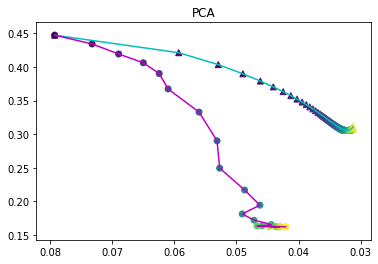

In [22]:
if ( flagAEType == 0 ) :
    LVarDescent = loss4DVarPCA.shape[0]
    LLSTMDescent = loss_LSTMDescentPCA.shape[0]

    plt.figure(2)
    plt.plot(loss4DVarPCA[:,0], loss4DVarPCA[:,1],'c-')
    plt.scatter(loss4DVarPCA[:,0], loss4DVarPCA[:,1], c=np.arange(LVarDescent),marker='^')
    plt.plot(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1],'m-')
    sca = plt.scatter(loss_LSTMDescentPCA[:,0], loss_LSTMDescentPCA[:,1], c=np.arange(LLSTMDescent),marker='o')
    #plt.yscale('log')
    sca.axes.invert_xaxis()
    plt.title('PCA')

In [23]:
if ( flagAEType == 1 ) :
    LVarDescent = loss4DVarAE.shape[0]
    LLSTMDescent = loss_LSTMDescentAE.shape[0]

    plt.figure(2)
    plt.plot(loss4DVarAE[:,0], loss4DVarAE[:,1],'c-')
    plt.scatter(loss4DVarAE[:,0], loss4DVarAE[:,1], c=np.arange(LVarDescent),marker='^')
    plt.plot(loss_LSTMDescentAE[:,0], loss_LSTMDescentAE[:,1],'m-')
    sca = plt.scatter(loss_LSTMDescentAE[:,0], loss_LSTMDescentAE[:,1], c=np.arange(LLSTMDescent),marker='o')
    #plt.yscale('log')
    sca.axes.invert_xaxis()
    plt.title('AE')

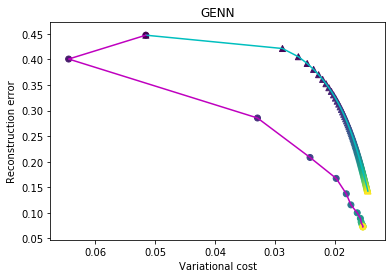

In [23]:
if ( flagAEType == 2) :
    LVarDescent = loss4DVar2SCNN.shape[0]
    LLSTMDescent = loss_LSTMDescent2SCNN.shape[0]

    plt.figure(2)
    plt.plot(loss4DVar2SCNN[:,0], loss4DVar2SCNN[:,1],'c-')
    plt.scatter(loss4DVar2SCNN[:,0], loss4DVar2SCNN[:,1], c=np.arange(LVarDescent),marker='^')
    plt.plot(loss_LSTMDescent2SCNN[:,0], loss_LSTMDescent2SCNN[:,1],'m-')
    sca = plt.scatter(loss_LSTMDescent2SCNN[:,0], loss_LSTMDescent2SCNN[:,1], c=np.arange(LLSTMDescent),marker='o')
    #plt.yscale('log')
    sca.axes.invert_xaxis()
    plt.xlabel('Variational cost')
    plt.ylabel('Reconstruction error')
    plt.title('GENN')

...... Reconstruction error 
.. Initialisation: 1.7611e+00
.. 2SCNN-FSGD : 2.1749e-01
.. 2SCNN-LSTM.  : 8.3223e-02


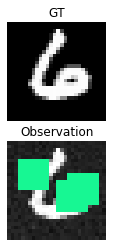

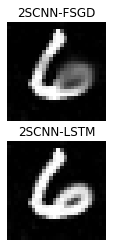

In [29]:
from matplotlib.colors import ListedColormap
grayCMAP  = plt.get_cmap('gray', 256)
newcolors = grayCMAP(np.linspace(0, 1, 256))
green     = np.array([24/256, 248/256, 148/256, 1])

ii    = 0

Vmin = (0-meanTr)/stdTr
Vmax = (255-meanTr)/stdTr
plt.figure(1)
plt.subplot(2,1,1)
plt.imshow(x_test[idxTt[ii],:,:].squeeze(),cmap='gray')
plt.axis('off')
plt.title('GT')

newcolors[0:1, :] = green
newcmp = ListedColormap(newcolors)

imvisu = np.copy(x_test_obs[idxTt[ii],:,:].squeeze())
imvisu[ np.where( mask_test[idxTt[ii],:,:] == 0.0) ] = Vmin-10
imvisu = (imvisu - Vmin) / (Vmax-Vmin)

plt.subplot(2,1,2)
#plt.figure(2)
plt.imshow(imvisu,cmap=newcmp,vmin=-0.15,vmax=1)
plt.axis('off')
plt.title('Observation')

if 'y_pred_VarMinPCA' in locals():
    plt.figure(2)
    plt.subplot(2,1,1)
    #plt.figure(4)
    plt.imshow(y_pred_VarMinPCA[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('PCA-FSGD')

    plt.subplot(2,1,2)
    #plt.figure(5)
    plt.imshow(y_pred_LSTMDescentPCA[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('PCA-LSTM')

if 'y_pred_VarMin2SCNN' in locals():
    plt.figure(3)
    plt.subplot(2,1,1)
    #plt.figure(4)
    plt.imshow(y_pred_VarMin2SCNN[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('2SCNN-FSGD')

    plt.subplot(2,1,2)
    #plt.figure(5)
    plt.imshow(y_pred_LSTMDescent2SCNN[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('2SCNN-LSTM')

if 'y_pred_VarMinAE' in locals():
    plt.figure(4)
    plt.subplot(2,1,1)
    #plt.figure(4)
    plt.imshow(y_pred_VarMinAE[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('AE-FSGD')

    plt.subplot(2,1,2)
    #plt.figure(5)
    plt.imshow(y_pred_LSTMDescentAE[0,:,:].squeeze(),cmap='gray',vmin=Vmin,vmax=Vmax)
    plt.axis('off')
    plt.title('AE-LSTM')


print('...... Reconstruction error ')
print('.. Initialisation: %.4e'%np.mean( (x_test_Init[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
if 'y_pred_VarMinPCA' in locals():
    print('.. PCA-FSGD : %.4e'%np.mean( (y_pred_VarMinPCA[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
    print('.. PCA-LSTM.  : %.4e'%np.mean( (y_pred_LSTMDescentPCA[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
if 'y_pred_VarMinAE' in locals():
    print('.. AE-FSGD : %.4e'%np.mean( (y_pred_VarMinAE[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
    print('.. AE-LSTM.  : %.4e'%np.mean( (y_pred_LSTMDescentAE[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
if 'y_pred_VarMin2SCNN' in locals():
    print('.. 2SCNN-FSGD : %.4e'%np.mean( (y_pred_VarMin2SCNN[0,:,:]-x_test[idxTt[ii],:,:])**2 ))
    print('.. 2SCNN-LSTM.  : %.4e'%np.mean( (y_pred_LSTMDescent2SCNN[0,:,:]-x_test[idxTt[ii],:,:])**2 ))

